In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
# 1. Read the data
df = pd.read_csv("Final_MRT.csv")

# 2. Select columns to normalize
features_to_normalize = [
    "tap_in", "tap_out",            # Labels
    "Visitors",                     # Feature
    "air_temperature", 
    "relative_humidity", 
    "wind_speed", 
    "rainfall"
]

# 3. Initialize the scaler
scaler = MinMaxScaler()

# 4. Apply normalization (keep original 'is_transfer_hub' and 'is_holiday' columns)
df_scaled = df.copy()
df_scaled[features_to_normalize] = scaler.fit_transform(df_scaled[features_to_normalize])

# 5. Save to a new file
df_scaled.to_csv("Final_MRT_Weather_Visitors_Holiday_Normalized.csv", index=False)

print("✅ Normalization completed and saved as Final_MRT_Weather_Visitors_Holiday_Normalized.csv")

In [6]:
# Read the normalized merged data
df = pd.read_csv("Final_MRT_Data_Normalized.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by station_id and timestamp
df = df.sort_values(by=['station_id', 'timestamp']).reset_index(drop=True)

# Feature columns (excluding labels)
feature_cols = [
    'Visitors', 'air_temperature', 'relative_humidity',
    'wind_speed', 'rainfall', 'is_transfer_hub', 'is_holiday'
]

# Target columns
target_cols = ['tap_in', 'tap_out']

# Window size
past_hours = 6

# Construct sliding windows
X, y = [], []
stations = df['station_id'].unique()

for station in stations:
    station_df = df[df['station_id'] == station].reset_index(drop=True)
    for i in range(past_hours, len(station_df)):
        past_features = station_df.loc[i - past_hours:i - 1, feature_cols].values
        label = station_df.loc[i, target_cols].values
        X.append(past_features)
        y.append(label)

X = np.array(X)  # shape: (samples, past_hours, features)
y = np.array(y)  # shape: (samples, 2)

print("✅ Sliding window construction completed")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Save the processed data for model training
np.save("X_lstm.npy", X)
np.save("y_lstm.npy", y)


✅ Sliding window construction completed
X shape: (218747, 6, 7)
y shape: (218747, 2)


LSTM

In [ ]:
X = X.astype(np.float32)
y = y.astype(np.float32)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(2))  # Output: tap_in and tap_out

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # You can adjust the number of epochs
    batch_size=128,
    verbose=1
)

# Evaluate the model performance on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f"✅ Test MAE: {mae:.4f}")


Epoch 1/10


d:\jupyterNotebook\envs\ST5230\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1368/1368 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0019 - mae: 0.0260 - val_loss: 0.0015 - val_mae: 0.0217
Epoch 2/10
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0015 - mae: 0.0221 - val_loss: 0.0014 - val_mae: 0.0216
Epoch 3/10
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0015 - mae: 0.0218 - val_loss: 0.0014 - val_mae: 0.0209
Epoch 4/10
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0014 - mae: 0.0215 - val_loss: 0.0014 - val_mae: 0.0213
Epoch 5/10
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0015 - mae: 0.0216 - val_loss: 0.0014 - val_mae: 0.0204
Epoch 6/10
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0014 - mae: 0.0214 - val_loss: 0.0014 - val_mae: 0.0206
Epoch 7/10
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0014 - mae: 0.0213 - val_loss: 0.0014 - val_mae: 0.0209
Epoch 8/10
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0014 - mae: 0.0213 - val_loss: 0.0014 - val_mae: 0.0202
Epoch 9/10
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/st

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# ✅ Load the latest normalized dataset
df = pd.read_csv("Final_MRT_Data_Normalized.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 🎯 Select only the holiday records
holiday_data = df[df['is_holiday'] == 1].copy()

# Sort by time within each station
holiday_data = holiday_data.sort_values(by=['station_id', 'timestamp']).reset_index(drop=True)

# Feature columns and target columns
feature_cols = ["is_transfer_hub", "air_temperature", "relative_humidity", 
                "wind_speed", "rainfall", "Visitors", "is_holiday"]
target_cols = ["tap_in", "tap_out"]

# Sliding window size
window_size = 6

X_holiday = []
y_holiday = []

# Build sliding windows for each station
for station_id, group in holiday_data.groupby("station_id"):
    group = group.reset_index(drop=True)
    for i in range(len(group) - window_size):
        X_holiday.append(group[feature_cols].iloc[i:i+window_size].values)
        y_holiday.append(group[target_cols].iloc[i+window_size].values)

X_holiday = np.array(X_holiday, dtype=np.float32)
y_holiday = np.array(y_holiday, dtype=np.float32)

# ✅ Model prediction
y_pred = model.predict(X_holiday)

# Filter out records where true values are 0 to avoid MAPE explosion
mask = (y_holiday[:, 0] > 1e-4) | (y_holiday[:, 1] > 1e-4)
y_filtered = y_holiday[mask]
y_pred_filtered = y_pred[mask]

# 📊 Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_filtered, y_pred_filtered))
mae = mean_absolute_error(y_filtered, y_pred_filtered)
mape = mean_absolute_percentage_error(y_filtered, y_pred_filtered)

print(f"🎯 Holiday RMSE: {rmse:.4f}")
print(f"🎯 Holiday MAE : {mae:.4f}")
print(f"🎯 Holiday MAPE: {mape:.4f}")


2104/2104 ━━━━━━━━━━━━━━━━━━━━ 2s 727us/step
🎯 节假日 RMSE: 0.0196
🎯 节假日 MAE : 0.0144
🎯 节假日 MAPE: 64483622912.0000


6836/6836 ━━━━━━━━━━━━━━━━━━━━ 5s 733us/step
🎯 Station with smallest MAE: CC19/DT9, MAE = 0.0143


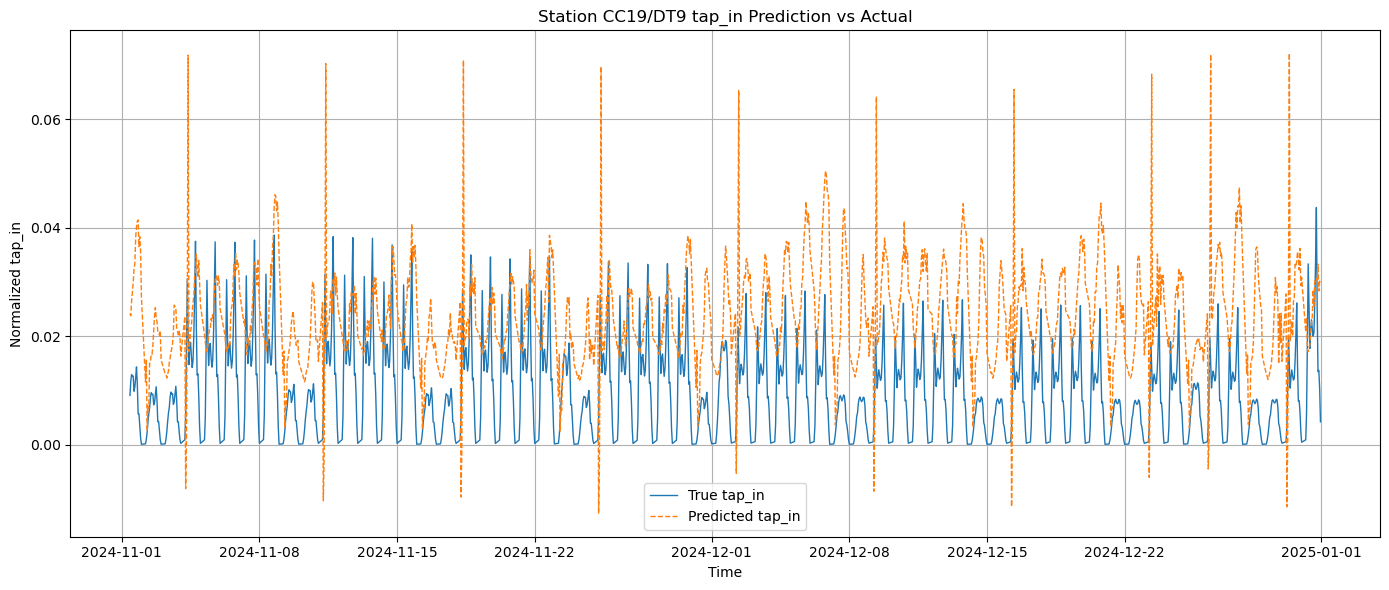

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# ✅ Load the normalized dataset
df = pd.read_csv("Final_MRT_Data_Normalized.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# ✅ Feature columns and target columns
feature_cols = [
    "is_transfer_hub", "air_temperature", "relative_humidity", 
    "wind_speed", "rainfall", "Visitors", "is_holiday"
]
target_cols = ["tap_in", "tap_out"]

# ✅ Build sliding window sequences (for model input)
sequence_length = 6
X_all, y_all, stations, timestamps = [], [], [], []
for station_id, group in df.groupby("station_id"):
    group = group.sort_values("timestamp")
    features = group[feature_cols].values
    targets = group[target_cols].values
    time_list = group["timestamp"].values
    for i in range(sequence_length, len(group)):
        X_all.append(features[i-sequence_length:i])
        y_all.append(targets[i])
        stations.append(station_id)
        timestamps.append(time_list[i])

X_all = np.array(X_all, dtype=np.float32)
y_all = np.array(y_all, dtype=np.float32)

# ✅ Model prediction (make sure model is loaded or trained)
y_pred_all = model.predict(X_all)

# ✅ Calculate MAE for each station
station_mae = {}
for station in set(stations):
    indices = [i for i, s in enumerate(stations) if s == station]
    mae = mean_absolute_error(y_all[indices], y_pred_all[indices])
    station_mae[station] = mae

# ✅ Find the station with the smallest MAE
best_station = min(station_mae, key=station_mae.get)
print(f"🎯 Station with smallest MAE: {best_station}, MAE = {station_mae[best_station]:.4f}")

# ✅ Get the corresponding data for the best station
indices = [i for i, s in enumerate(stations) if s == best_station]
time_axis = [timestamps[i] for i in indices]

# ✅ Plot and save as vectorized PDF
plt.figure(figsize=(14, 6))
plt.plot(time_axis, y_all[indices][:, 0], label="True tap_in", linewidth=1)
plt.plot(time_axis, y_pred_all[indices][:, 0], label="Predicted tap_in", linestyle='--', linewidth=1)
plt.title(f"Station {best_station} tap_in Prediction vs Actual")
plt.xlabel("Time")
plt.ylabel("Normalized tap_in")
plt.legend()
plt.grid(True)
plt.tight_layout()

# ✅ Save the figure as a vectorized PDF file
plt.savefig("tap_in_prediction_vector.pdf", format="pdf")

# (Optional) Show the figure
plt.show()
